In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Load Dataset

In [4]:
datamining_dir = "/gdrive/MyDrive/Data Mining - 255/"

X_train = np.load(datamining_dir + "train_X.npy")
X_test = np.load(datamining_dir + "test_X.npy")
y_train = np.load(datamining_dir + "train_Y.npy")
y_test = np.load(datamining_dir + "test_Y.npy")

X_train_imgs = np.stack((X_train, X_train, X_train), axis=3)
X_test_imgs = np.stack((X_test, X_test, X_test), axis=3)


print("X_train shape ", X_train_imgs.shape)
print("y_train shape ", y_train.shape)
print("X_test shape ", X_test_imgs.shape)
print("y_test shape ", y_test.shape)

X_train shape  (16653, 64, 64, 3)
y_train shape  (16653,)
X_test shape  (4163, 64, 64, 3)
y_test shape  (4163,)


## Display few images

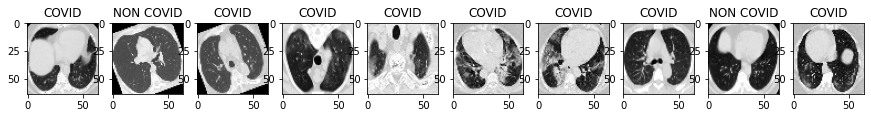

In [5]:
fig, axes = plt.subplots(1,10,figsize=(15,15))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title("COVID" if y_train[i] == 0 else "NON COVID")

## Preparing Feature Extractor Model

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

dims = 64
resnet = ResNet50(include_top=False, input_shape=(dims, dims, 3))

for layer in resnet.layers:
    layer.trainable = False
    
model = tf.keras.layers.Flatten()(resnet.output)
model = Model(resnet.input, model)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
__________________________________________________________________________________________________
None


## Extracting Features via CNN (Resnet50)

In [7]:
X_train_out = model.predict(X_train_imgs)
X_test_out = model.predict(X_test_imgs)

print("X_train_out shape ", X_train_out.shape)
print("X_test_out shape ", X_test_out.shape)

X_train_out shape  (16653, 8192)
X_test_out shape  (4163, 8192)


## Applying PCA on extracted features

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.8)
pca.fit(X_train_out)

X_train_red = pca.transform(X_train_out)
X_test_red = pca.transform(X_test_out)

print("X_train_red shape ", X_train_red.shape)
print("X_test_red shape ", X_test_red.shape)

X_train_red shape  (16653, 86)
X_test_red shape  (4163, 86)


## Fit SVM Classifier

In [9]:
svm_classifier = svm.SVC(kernel='linear').fit(X_train_red, y_train)
y_pred = svm_classifier.predict(X_test_red)
print('Accuracy ', accuracy_score(y_test, y_pred))

Accuracy 0.7686764352630314


In [10]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Confusion Matrix

Confusion matrix, without normalization
[[1290  548]
 [ 415 1910]]


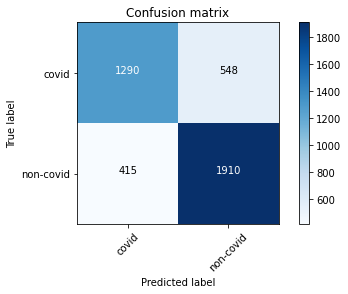

In [11]:
y_pred = np.around(y_pred.reshape(y_test.shape))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['covid', 'non-covid'],
                      title='Confusion matrix')

## Fscore, Precision, Recall

In [12]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
print("Precision of (covid, non-covid): ", precision)
print("Recall of (covid, non-covid): ", recall)
print("Fscore of (covid, non-covid): ", fscore)

Precision of (covid, non-covid):  [0.75659824 0.77705452]
Recall of (covid, non-covid):  [0.70184984 0.82150538]
Fscore of (covid, non-covid):  [0.72819644 0.79866193]
